# Walk1D

This example demonstrates local stress testing in a 1D random walk environment.
- **System under test:** inactive; does nothing to control pawn movement or avoid failure.
- **Failure criterion:** pawn position exceeds critical value.
- **Stochastic disturbance:** 1-dimensional pawn movement, normally distributed.

In this case, the AST problem reduces to a simple goal-seeking reinforcement learning problem. This allows us to easily evaluate the efficacy of the solvers.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate

  Activating environment at `C:\Users\rlipkis\.julia\dev\adastress\examples\walk1d\Project.toml`


instantiate (generic function with 2 methods)

In [2]:
using AdaStress
import AdaStress.BlackBox
using Plots

## Simulation

In [3]:
using Distributions
using Random

In [4]:
Base.@kwdef mutable struct Walk1D <: AdaStress.BlackBox
    t::Float64=0.0
    t_max::Float64=10.0
    x::Float64=0.0
    x_fail::Float64=10.0
    dist::Normal=Normal(0.0, 1.0)
end

function initialize!(sim::Walk1D)
    sim.t = 0.0
    sim.x = 0.0
end

function update!(sim::Walk1D)
    sim.t += 1.0
    a = rand(sim.dist)
    sim.x += a
    return logpdf(sim.dist, a) - logpdf(sim.dist, 0.0)
end

update! (generic function with 1 method)

In [5]:
AdaStress.reset!(sim::Walk1D) = initialize!(sim)
AdaStress.step!(sim::Walk1D) = update!(sim)
AdaStress.isterminal(sim::Walk1D) = sim.t >= sim.t_max
AdaStress.isevent(sim::Walk1D) = sim.x >= sim.x_fail
AdaStress.distance(sim::Walk1D) = max(sim.x_fail - sim.x, 0.0)

## MCS

In [6]:
mcs = AdaStress.Solvers.MCS(num_iterations=100_000)

AdaStress.Solvers.MonteCarloSearch.MCS(100000, 10)

In [7]:
mdp = AdaStress.ASTMDP(Walk1D())
mdp.reward.event_bonus = 100.0

100.0

In [8]:
Random.seed!(0)
@time sol = mcs(() -> mdp)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


 14.257129 seconds (29.35 M allocations: 1.010 GiB, 1.49% gc time, 14.12% compilation time)


DataStructures.PriorityQueue{Any, Any, Base.Order.ForwardOrdering} with 10 entries:
  UInt32[0xeff14857, 0x80aa8b17, 0x60cbb52a, 0xc7adaa61, 0x8396285d,… => 102.006
  UInt32[0xb92e356d, 0xdeba480c, 0x606ae90e, 0x9e5c4aa0, 0xf0060a6e,… => 102.007
  UInt32[0xcd1f8b74, 0x2afe5ca4, 0xf669453a, 0xad8d867d, 0x6f812e32,… => 102.071
  UInt32[0xefa754cd, 0xe22fc1c5, 0xebfd0f38, 0x83180c7a, 0x1a6c4ece,… => 102.081
  UInt32[0x664255d2, 0x40c581fb, 0xa79f9fd3, 0xfe977a2d, 0x5abc8863,… => 102.117
  UInt32[0xa4164c2a, 0x1c70195f, 0xe1b7614a, 0xc262a5b8, 0xdde86baf,… => 102.193
  UInt32[0x989ff3a4, 0xe5498926, 0x72c4d693, 0x021bb825, 0x0cbc157e,… => 102.226
  UInt32[0xb88e140d, 0x70d080ac, 0xe3332922, 0x52220bba, 0x0568c57f,… => 102.227
  UInt32[0xcda6db5a, 0xd23349c0, 0x4805d9c2, 0x49fc2010, 0xb250c66f,… => 102.393
  UInt32[0x4536c787, 0x00d750eb, 0x0409d7f2, 0x0fd07702, 0xaddfb80b,… => 103.186

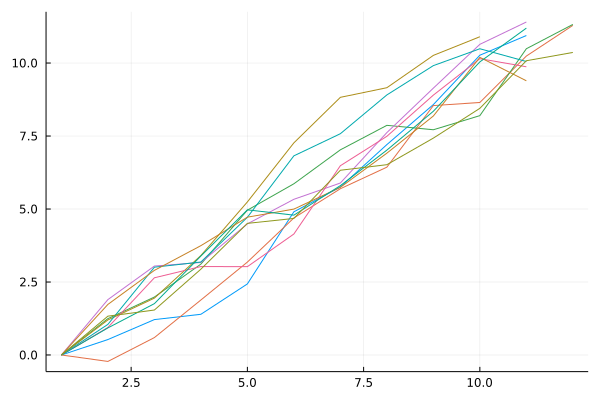

In [9]:
p = plot(legend=false)
for (path, r) in sol
    Interface.reset!(mdp)
    x = [mdp.sim.x]
    for a in path
        Interface.act!(mdp, a)
        push!(x, mdp.sim.x)
    end
    plot!(p, x)
end
p

## MCTS

In [10]:
mcts = AdaStress.Solvers.MCTS(num_iterations=100_000)

AdaStress.Solvers.MonteCarloTreeSearch.MCTS(100000, 10, 1.0, 0.7, 1.0, nothing)

In [11]:
Random.seed!(0)
@time sol = mcts(() -> mdp)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


 10.331220 seconds (25.65 M allocations: 919.690 MiB, 2.55% gc time, 4.51% compilation time)


DataStructures.PriorityQueue{Any, Any, Base.Order.ForwardOrdering} with 10 entries:
  UInt32[0x9458f8c0, 0xadf24b77, 0x3a1400de, 0x0575c4a6, 0x546b4bdf,… => 102.909
  UInt32[0x9458f8c0, 0xadf24b77, 0x3a1400de, 0x0575c4a6, 0xa4795f81,… => 102.926
  UInt32[0x9458f8c0, 0xadf24b77, 0x4b5a79fa, 0xae8b1eea, 0x1747db5b,… => 103.03
  UInt32[0x9458f8c0, 0xadf24b77, 0x3a1400de, 0x5b629182, 0x4027b204,… => 103.037
  UInt32[0x9458f8c0, 0xadf24b77, 0x3a1400de, 0x0575c4a6, 0x2e7f05b9,… => 103.104
  UInt32[0x9458f8c0, 0xadf24b77, 0x3a1400de, 0x0575c4a6, 0x6624ad18,… => 103.365
  UInt32[0x9458f8c0, 0xadf24b77, 0x3a1400de, 0x0575c4a6, 0x2e7f05b9,… => 103.459
  UInt32[0x9458f8c0, 0xadf24b77, 0x3a1400de, 0x0575c4a6, 0x2e7f05b9,… => 103.498
  UInt32[0x9458f8c0, 0xadf24b77, 0x3a1400de, 0x0575c4a6, 0x24e09ae8,… => 103.519
  UInt32[0x9458f8c0, 0xadf24b77, 0x3a1400de, 0x0575c4a6, 0x6821daf0,… => 103.677

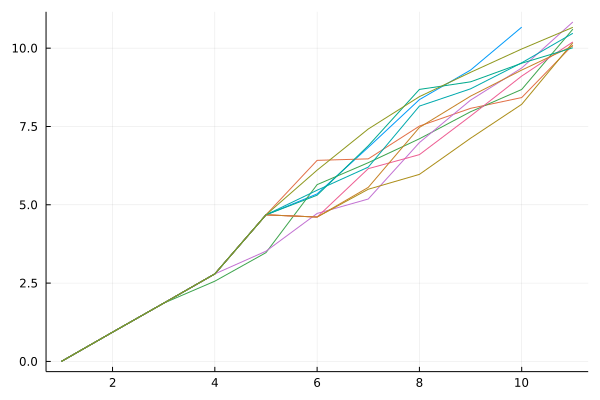

In [12]:
p = plot(legend=false)
for (path, r) in sol
    Interface.reset!(mdp)
    x = [mdp.sim.x]
    for a in path
        Interface.act!(mdp, a)
        push!(x, mdp.sim.x)
    end
    plot!(p, x)
end
p